# A test for the risk-budgeting model

## Data/Stock choosing:

1. Use stock code [600519,600030,601857,601628], four representative stock in their respective industry to do the test.

2. Monthly period from 2010 - 2022. 


In [2]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import test_result

# 洗数据的地方别管 到时候要改

In [3]:
stock_list = [600519,600030,601857,601628]
def data_prep(stock_list):
    raw_data = pd.read_csv('TRD_Mnth.csv',parse_dates=True)
    rf = pd.read_csv('./clean_data/rf_rate.csv').value.values
    df = pd.DataFrame()
    df['date'] = raw_data[raw_data['Stkcd'] == 600000].Trdmnt.values
    for i in range(len(stock_list)):
        df[stock_list[i]] = raw_data[raw_data['Stkcd'] == stock_list[i]].Mretwd.values
    df.to_csv('./clean_data/cleaned_data.csv')

In [4]:
def data_seperate():
    df = pd.read_csv('./clean_data/cleaned_data.csv',index_col=1, parse_dates=True,infer_datetime_format = True).drop(columns='Unnamed: 0')
    train = df[df.index.year <= 2015]
    test = df[df.index.year > 2015]
    train.to_csv('./clean_data/train.csv')
    test.to_csv('./clean_data/test.csv')

In [5]:
#这里还要改下
data_prep(stock_list)
data_seperate()

# Construct Portfolio

* objective function: min $\Sigma_{i=1}^N RC_i(w)$ (suppose N stocks)

$RC_i(W) = \frac{w_i(\Sigma w)_i}{(w^T\Sigma w)^{0.5}}$

* two constraint: no short sellings; full activate trader


* Following the logic from sta4020 asg7. Starting from the end of 2015, at the end of every month, use the historical asset returns (from 2011/1 to the end of that month).

In [6]:
"""
This file constructs a strategic ERP portfolio and compare with an equal weighted portfolio.
x: portfolio weights
p_cov: covariance matrix
"""


# risk budgeting approach optimisation object function
def obj_fun(x, p_cov):
	return np.sum((x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x)))**2)


# constraint on sum of weights equal to one
def cons_sum_weight(x):
	return np.sum(x)-1.0


# constraint on weight larger than zero
def cons_long_only_weight(x):
	return x


# calculate risk budgeting portfolio weight give risk budget
def rb_p_weights(asset_rets):
	# number of ARP series
	num_arp = asset_rets.shape[1]
	# covariance matrix of asset returns
	p_cov = asset_rets.cov()
	# initial weights
	w0 = 1.0 * np.ones((num_arp, 1)) / num_arp
	# constraints
	cons = ({'type': 'eq', 'fun': cons_sum_weight}, {'type': 'ineq', 'fun': cons_long_only_weight})
	# portfolio optimisation
	return minimize(obj_fun, w0, args=(p_cov), method='SLSQP', constraints=cons)



	# 1. Load ARP data
	

In [7]:
train_data = pd.read_csv('./clean_data/train.csv',index_col=0, parse_dates=True,infer_datetime_format = True)
test_data = pd.read_csv('./clean_data/test.csv',index_col=0, parse_dates=True,infer_datetime_format = True)
#train_rf = pd.read_csv('./clean_data/rf_rate_training.csv')
#test_rf = pd.read_csv('./clean_data/rf_rate_testing.csv')
#data = pd.read_csv('./clean_data/cleaned_data.csv',index_col=1, parse_dates=True,infer_datetime_format = True).drop(columns='Unnamed: 0')
# 2. calculate excess returns


# 3. Construct risk budgeting portfolio
# portfolio dates
p_dates = test_data.index
data = pd.concat([train_data,test_data])
# initialise portfolio weights matrix
w = pd.DataFrame(index=p_dates, columns=data.columns)
# initialise portfolio return matrix
p_rets = pd.DataFrame(index=p_dates, columns=['return'])

for t in p_dates:

	# re-balance the portfolio each month
	tmp_portfolio = data[data.index < t]
	w.loc[t] = rb_p_weights(tmp_portfolio).x

	# calculate risk budgeting portfolio returns
	p_rets.loc[t] = np.sum(w.loc[t] * data.loc[t])


# 回测

In [9]:
test_result.calculate_result(p_rets)

,accu_return,annual_return,annual_vol,sharpe_ratio,max_dd,winning_rate,karmar
0,1.244323,0.123982,1.462848,0.077918,-0.217761,0.614458,5.714169


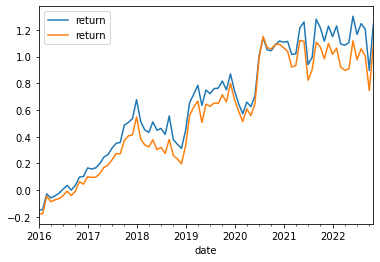

In [12]:
# 4. Construct equal weighted portfolio

ew_rets = pd.DataFrame(np.sum(1.0*data[data.index>=p_dates[0]]/data.shape[1], axis=1), columns=['return'])

# 5. Plot the portfolio cumulative returns
p_cumrets = (p_rets['return'] + 1).cumprod()-1
ew_cumrets = (ew_rets['return'] + 1).cumprod()-1

pd.concat([p_cumrets, ew_cumrets], axis=1).plot()
plt.show()

* maximize the sharp ratio and the formula derivation: this repository may helps

https://github.com/PaiViji/PythonFinance--RiskBudgeted-Portfolio-Construction.git

* we can also use this repository to check the quality of our work:

https://github.com/jcrichard/pyrb.git